# Scenario

In deze notebook ga ik stap voor stap door de data die we gebruiken voor de video over de extreme infospheren op YouTube.

Doelen van de video: 

1. Kijkers laten zien hoe groot en extreem deze infospheren zijn. 
2. Kijkers bekend maken met de belangrijkste ideeen en richtingen in deze infospheren.

Dit doen we door telkens te wisselen tussen macroniveau (hoe ziet die sphere eruit als je erboven hangt, dus hoe verhouden kanalen zich tot elkaar, tot andere spheres en tot andere media) en microniveau (wat gebeurt er nu eigenlijk in en onder die video's, hoe gedragen reaguurders zich?)

Daarvoor hebben we deze graphics nodig die de rode draad vormen van het scenario.

1. Belang YT in mediaconsumptie
2. Relatieve omvang van de spheres op YT (socialblade).
3. Aard en omvang van kanalen, verteld aan de hand van enkele representatieve kanalen.
4. Groei van de spheres - gapminder (10 geselecteerden) / onderwerp
5. Onderwerpen die behandeld worden (4 of 5, waaronder antifeminisme, biologisch racisme, vluchtelingen en migratie, antisemitisme, islamofobie.
6. Inzoomen op enkele reaguurders-communities (op groepsniveau en enkele individuen)

## Een paar praktische zaken

- Voor een aantal analyes en bewerkingen gebruik ik functies die je vindt in scenariofunctions.py. Het gaat daarbij vooral om schoonmaken van socialblade data (socialblade_ranking, socialblade_growth), filteren van kanalen (channel_filter), comments (comment_filter) en xxxx.
- M.n. de commentfiles zijn zeer vies en ik had veel problemen met parsen. Ik gebruik daarom zeer zeldzame, maar ook ongebruikelijke separators en quotechars. Daarmee lijkt het goed te gaan. 
- De paths naar de data heb ik in config.py ondergebracht. Maak er dus een aan die betrekking heeft op jouw filesystem. 
- Voor alles geldt: python3.x

In [ ]:
%load_ext autoreload
%autoreload 2

In [127]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt 
import datetime as dt
import scenariofunctions as sf
import glob 
import csv 
import re
import sys
import os
import config

csv.field_size_limit(sys.maxsize)
%matplotlib inline

In [23]:
path_nl = config.PATH_NL
path_right = config.PATH_RIGHT
path_left = config.PATH_LEFT
path_viz = config.PATH_VIZ

## Belang YT in mediaconsumptie

Bronnen: 

1. [Mediamonitor 2018](https://www.cvdm.nl/wp-content/uploads/2018/06/Mediamonitor-2018-Reuters-Institute-Digital-News-Report-Nederland-2018.pdf)
2. [Marketingfacts](https://www.marketingfacts.nl/berichten/jongeren-keren-facebook-massaal-de-rug-toe)
3. [Pew research center](http://www.pewinternet.org/2018/05/31/teens-social-media-technology-2018/)



In [3]:
# Marketingfacts, percentage dat ... gebruikt.

data = {'WhatsApp':[97, 93, 86, 67, 38],
        'Facebook':[72, 89, 77, 69, 58],
        'YouTube':[86, 74, 54, 38, 21],
        'LinkedIn':[12, 45, 36, 14, 7],
        'Instagram':[73, 46, 22, 9, 6],
        'Twitter':[23, 26, 21, 9, 9],
        'Pinterest':[19, 30, 21, 12, 8],
        'Snapchat':[72, 32, 7, 1, 1]       
       }

marketingfacts = pd.DataFrame.from_dict(data, orient='index',
                             columns=['15-19 jaar', '20-39 jaar', '40-64 jaar', '65-79 jaar', '80+'])

In [4]:
marketingfacts

,15-19 jaar,20-39 jaar,40-64 jaar,65-79 jaar,80+
WhatsApp,97,93,86,67,38
Facebook,72,89,77,69,58
YouTube,86,74,54,38,21
LinkedIn,12,45,36,14,7
Instagram,73,46,22,9,6
Twitter,23,26,21,9,9
Pinterest,19,30,21,12,8
Snapchat,72,32,7,1,1


In [5]:
# Pew, perentage tieners die 

data = {'Youtube': [85, 32],
        'Instagram': [72, 15],
        'Snapchat': [69, 35],
        'Facebook': [51, 10],
        'Twitter': [32, 3],
        'Tumblr': [9, 1],
        'Reddit': [7, 1],
        'Geen van bovenstaande': [3, 3]
       }

pew = pd.DataFrame.from_dict(data, orient='index',
                            columns=['Zegt te gebruiken', 'Zegt het meest te gebruiken'])

In [6]:
pew

,Zegt te gebruiken,Zegt het meest te gebruiken
Youtube,85,32
Instagram,72,15
Snapchat,69,35
Facebook,51,10
Twitter,32,3
Tumblr,9,1
Reddit,7,1
Geen van bovenstaande,3,3


## Relatieve omgang van de spheres

Socialblade gebruikt een eigen ranking die gebaseerd is op viewcount, subscribercount en nog een paar zaken die ze niet openbaar heeft gemaakt. Dit geeft een idee waar we bepaalde kanalen moeten plaatsen binnen YouTube, hoe groot en invloedrijk ze zijn. 

Enkele voorbeelden:

Volkskrant ranks:
- Grade: C+
- Subscriber rank: 1,001,161st
- Video view rank: 502,428th
- Socialblade rank: 523,376th
- Estimated Monthly Earnings: €29 - €459
- Estimated Yearly Earnings: €344 - €5.5K

De Correspondent ranks:
- Grade: C
- Subscriber rank: 1,832,426th
- Video view rank: 5,212,726th
- Socialblade rank: 4,469,657th
- Estimated Monthly Earnings: €0.47 - €8
- Estimated Yearly Earnings: €6 - €90

The New York Times ranks:
- Grade: B+
- Subcriber rank: 5,443rd
- Video view rank: 3,210th
- Socialblade rank: 8,201st
- Estimated Monthly Earnings: €5.2K - €82.4K
- Estimated Yearly Earnings: €61.8K - €989.2K


In [7]:
spheres = ['right', 'nl_right', 'left']
channel_rankings = pd.DataFrame()

for sphere in spheres:
    if sphere == 'nl_right':
        write_sphere = 'nl_right'
        path = config.PATH_NL
    elif sphere == 'left':
        write_sphere = 'left'
        path = config.PATH_LEFT
    elif sphere == 'right':
        write_sphere = 'right'
        path = config.PATH_RIGHT
    else:
        print('no valid sphere')

    socialblade_input = pd.read_csv(path + 'other_platforms/socialblade_' + sphere + '_summary.csv')
    socialblade = sf.socialblade_ranking(socialblade_input)
    socialblade['sphere'] = write_sphere
    channels_sphere = pd.read_csv(path + 'channels_' + sphere + '.csv', usecols=['channel_id','channel_title'])
    ranking = pd.merge(socialblade, channels_sphere, on='channel_id', how='left')
    channel_rankings = channel_rankings.append(ranking)

channel_rankings.to_csv(path_viz + 'socialblade_channel_rankings.csv')

Wat is de verdeling links/rechts/NL (dat eigenlijk ook rechts is)?

In [8]:
channel_rankings.sphere.value_counts()

right       739
left        615
nl_right     50
Name: sphere, dtype: int64

Laten we eens kijken wat de verdeling is qua 'grades'. Bedenk: de rechtse sfeer is zo'n vijftien procent groter dan de linkse.

In [9]:
grades = channel_rankings.groupby(['grade', 'sphere']).size()
grades

grade  sphere  
B      left         19
       nl_right      2
       right        32
B+     left          2
       right         4
B-     left         17
       nl_right      1
       right        21
C      left        146
       nl_right      9
       right       177
C+     left        191
       nl_right     22
       right       261
C-     left         40
       nl_right      2
       right        36
D      left         12
       nl_right      2
       right        16
D+     left         18
       right        18
D-     left        170
       nl_right     11
       right       173
TBD    nl_right      1
       right         1
dtype: int64

Ze ontlopen elkaar dus niet zoveel.

## Groei van de spheres

Hiervoor gebruiken we in eerste instantie cijfers van socialblade.com. Probleem is dat die maar teruggaan tot 2015. Dus ik wil ook nog de video's gebruiken. Probleem is alleen dat die cijfers minder kloppen omdat oude videos relatief hoge viewcounts hebben, omdat die lang nadien nog bekeken kunnen worden. Een video uit 2011 kan nu nog steeds viewcounts krijgen. Socialblade bakent dit af per maand, dus is nauwkeuriger. Maar laten we het gewoon allebei proberen. 

In [34]:
spheres = ['right', 'nl_right', 'left']
channel_history = pd.DataFrame()

for sphere in spheres:
    if sphere == 'nl_right':
        write_sphere = 'nl_right'
        path = config.PATH_NL
    elif sphere == 'left':
        write_sphere = 'left'
        path = config.PATH_LEFT
    elif sphere == 'right':
        write_sphere = 'right'
        path = config.PATH_RIGHT
    else:
        print('no valid sphere')

    socialblade_input = pd.read_csv(path + 'other_platforms/socialblade_' + sphere + '_monthly.csv')
    socialblade = sf.socialblade_growth(socialblade_input)
    socialblade['sphere'] = write_sphere
    channels_sphere = pd.read_csv(path + 'channels_' + sphere + '.csv', usecols=['channel_id','channel_title'])
    growth = pd.merge(socialblade, channels_sphere, on='channel_id', how='left')
    channel_history = channel_history.append(growth, sort=False)
    channel_history = channel_history[['channel_title', 'yearmonth', 'subs', 'views', 'sphere']]

In [35]:
channel_history.to_csv(path_viz + 'gapminder_monthly_growth_based_on_socialblade.csv', index=False)
del channel_history

[Hier](https://drive.google.com/open?id=16NFYBBD87ZP0o5Mm3z8j0RbucceAxq-i) vind je de gapminder file die de ontwikkeling van de kanalen sinds 2015 laat zien. Hiervoor moet je wel gapminder downloaden. Dat kan [hier](https://www.gapminder.org/tools-offline/).

Korte analyse: het is alsof iemand een bak stuiterballen heeft omgekeerd. Je ziet wel een aantal dingen:
1. Een paar kanalen zijn echt heel groot. The Young Turks overheerst alles. 
2. Er is zeker sprake van een flinke groei van de kanalen, zowel links en rechts. Ik heb de indruk dat het middensegment, dus niet klein, maar ook niet groot, dat daar wat meer rechtse kanalen zitten. Links heeft een paar hele grote en vrij veel kleine kanalen. 
3. Zo rond 2016 en 2017 vindt die groei vooral plaats.

Het kan nuttig zijn een subset te nemen. Bijvoorbeeld deze:

Voorstel:

- 'Stefan Molyneux', (bekend en al sinds 2008 actief)
- 'Red Ice TV', (populair en Europees)
- 'Millennial Woes', (invloedrijk, doch een behoorlijke randfiguur)
- 'Andywarski', (zou een gematigd figuur moeten zijn, maar biedt ruimte aan extremen. vernieuwend format)
- 'Alt-Right Tankie- Eurasianist', (hardcore alt-right)
- 'The Alternative Hypothesis', (idem, met interessant game-format)
- 'Rebel Media', (zeer hard gegroeid, behoorlijk professioneel)
- 'Styxhexenhammer666', (vertegenwoordigt het occulte deel)
- 'Jean-Francois Gariépy', (Franse biologische racist die ook veel met andere youtubers samenwerkt)
- 'Gavin McInnes', (antifeminist, veel in het nieuws)
- 'Politiekman', (een van de weinige NL alt-right youtubers. recentelijk gestopt)
- 'Black Pigeon Speaks', (bekend kanaal, mag eventueel afvallen)
- 'Paul Joseph Watson', (vertegenwoordigt het conspiracy-deel. zeer populair)
- 'The Thinkery', (filosofische tak)
- 'Sargon of Akkad', (groot en directe relatie met de gamergate controverse)
- 'American Rennaissance', (white supremacy)
- 'Pat Condell', (zeer populair in NL, lijkt tanend te zijn)
- 'Vlad Tepesblog', (counter-jihadism. Loopt lang mee, en nog steeds populair)
- 'The Iconoclast', (hardcore alt-right)
- 'Dr. Steve Turley', (christelijke tak)
- 'Black Pilled', (hardcore alt-right, black pilled verwijst doorgaans naar incels)
- 'Blonde in the Belly of the Beast', (vrouw!)
- 'Brittany Pettibone', (vrouw, populair en omstreden)
- 'T Я U Σ Ð I L T O M', (brit, bedient zich van de fashwave stijl)
- 'AltRight.com' (kanaal van Richard Spencer)
- 'The Golden One'

In [36]:
selection = ['Stefan Molyneux',
             'Red Ice TV',
             'Millennial Woes',
             'Andywarski',
             'Alt-Right Tankie- Eurasianist',
             'The Alternative Hypothesis',
             'Rebel Media',
             'Styxhexenhammer666',
             'Jean-Francois Gariépy',
             'Gavin McInnes',
             'Politiekman',
             'Black Pigeon Speaks',
             'Paul Joseph Watson',
             'The Thinkery',
             'Sargon of Akkad',
             'American Rennaissance',
             'Pat Condell',
             'Vlad Tepesblog',
             'The Iconoclast',
             'Dr. Steve Turley',
             'Black Pilled',
             'Blonde in the Belly of the Beast',
             'Brittany Pettibone',
             'T Я U Σ Ð I L T O M',
             'AltRight.com',
             'The Golden One'
]

In [37]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right = sf.add_years_months_to_videos(videos_right)

In [38]:
vids_we_want = sf.channel_filter(videos_right, set(selection))

deze selectie levert 29394 videos op.


In [39]:
vids_grouped = vids_we_want.groupby(['video_channel_title', 'yearmonth'])[['video_view_count',
                                                                           'video_comment_count',
                                                                           'video_likes_count'
                                                                          
                                                                          ]].agg('sum')

In [44]:
vids_grouped.to_csv(path_viz + 'gapminder_monthly_growth_based_on_videos_selection.csv')
del vids_grouped
del vids_we_want
del videos_right

Je kunt de gapminder-file [hier](https://drive.google.com/open?id=18FUihglyZPN5v9fgMTB3tBZMUmR-oAfI) vinden.

Enkele bevindingen:

Ik vind de groei overduidelijk. Veel pieken in commentaren, views en likes. Het is duidelijk dat de kanalen vanaf zo'n 2013 een steeds groter publiek krijgen. Sommige kanalen (zoals Stefan Molyneux) zijn al heel lang bezig. Die pruttelden wat in de marge, maar zijn echt doorgebroken. Ik denk dat Molyneux een hele eigen analyse verdient, omdat hij zo groot is, al zo lang bezig is en bij zoveel onderwerpen opduikt.

Laten we toch nog even kijken naar alle video's.

In [54]:
spheres = ['right', 'nl_right', 'left']
channel_history = pd.DataFrame()

for sphere in spheres:
    if sphere == 'nl_right':
        write_sphere = 'nl_right'
        path = config.PATH_NL
    elif sphere == 'left':
        write_sphere = 'left'
        path = config.PATH_LEFT
    elif sphere == 'right':
        write_sphere = 'right'
        path = config.PATH_RIGHT
    else:
        print('no valid sphere')

    videos = pd.read_csv(path + 'videos_' + sphere + '.csv', encoding='latin-1')
    videos = sf.add_years_months_to_videos(videos)
    videos['sphere'] = write_sphere
    channel_history = channel_history.append(videos, sort=False)

vids_grouped = channel_history.groupby(['video_channel_title', 'yearmonth', 'sphere']) \
                                        [['video_view_count',
                                        'video_comment_count',
                                        'video_likes_count'
                                        ]].agg('sum')

In [57]:
vids_grouped.to_csv(path_viz + 'gapminder_monthly_growth_based_on_videos.csv')
del channel_history
del vids_grouped

[Hier de gapminder file.](https://drive.google.com/open?id=1huuxSspihHlcRl3qs4YHuc_POE-Ho0Ie) Interessant, interessant. Die groei zie je wel terug. Er is een aantal outliers die de boel nogal vertekenen, maar ik vind de groei echt opvallend (en het gaat om grote aantallen), maar ook: veel rechts hoor - rechts dat behoorlijk groot is. Nederland zie je niet eens terug.

## Waar gaan de videos over?

Laten we eerst kijken naar alle videos. Enkele onderwerpen die ik wil onderzoeken zijn:
1. De manosphere
2. Ras en IQ
3. Geweld
4. Antisemitisme
5. Anti-moslim
6. Vluchtelingen / migratie

Later kunnen we nog een paar andere onderwerpen eruit pakken en de selectie wat kleiner maken.

Ik ben naar een aantal dingen benieuwd.
1. Een aantal basale statistieken. Hoeveel komt een onderwerp voor? Wie maakt ze? Wanneer speelde het?
2. Zijn er content producers die opvallen? Wat voor content maken ze? Wat is de toon?
3. Welke relatie heeft het kanaal met andere kanalen? Daarbij wil ik kijken naar de commenters - waar zijn die nog meer actief? 
4. En we zouden nog kunnen kijken naar de aanbevelingen van de gevonden video's. 

Allereerst wil ik de tags gebruiken. Die zie je als gebruiker niet, maar die worden wel steevast door contentmakers aangemaakt en zijn best wel onthullend. Plus ook redelijk betrouwbaar lijkt me: het maakt hun content immers beter vindbaar. Later kunnen we ook nog andere technieken gebruiken, zoals topic modelling, maar dat lijkt me vooralsnog wat zwaar geschut.

### Manosphere

Goed, eerst de manosphere. Met onderstaande termen moeten we de videos kunnen vinden. De kunst is om de termen zo precies en afgebakend mogelijk te houden. Wat mij betreft kiezen we ook vrij extreme termen, zodat over de aard van de content, of extremiteit zo je wil, niet zoveel discussie hoeft te zijn.

In [58]:
query_topic = 'manosphere'

# Definieer de zoektermen en doe dat in zogenoemde regex-patronen.

query = ['mgtow', 'metoo', '^rape', 'rape cultur','proud boys', 'incel', 
         'pickup arti', 'rooshv', "men's right", 
         'men rights', 'manospher', 'mascul', 'hypergam', 
         'gynocentr', 'briffault', 'gold digg', 'whores', 
         'vagina', 'parasitic women', 'mens righ',
         'alpha fucks', 'misandry', 'alfa fux'
        ]


In [73]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right = sf.add_years_months_to_videos(videos_right)
topic = sf.topic_filter(videos_right, query, query_topic)

found 2941 videos with manosphere


We vinden dus 2941 video's die een van deze termen in hun tags hebben. Wat is hun totale viewcount?

In [74]:
topic.video_view_count.sum()

221003323.0

Wow, meer dan 220 miljoen! Vermoedelijk is het een stuk minder als je metoo weghaalt. We zouden de selectie nog wat extremer kunnen maken.

In [75]:
query_more_extreme = ['mgtow', '^rape', 'rape cultur','proud boys', 'incel', 
         'pickup arti', 'rooshv', 'manospher', 'hypergam', 
         'gynocentr', 'briffault', 'gold digg', 'whores', 
         'vagina', 'parasitic women',
         'alpha fucks', 'misandry', 'alfa fux'
        ]

In [78]:
topic_more_extreme = sf.topic_filter(videos_right, query_more_extreme, query_topic)

found 1857 videos with manosphere


In [79]:
topic_more_extreme.video_view_count.sum()

113965369.0

Nou ja, ook nog steeds veel. 114 miljoen views, afgerond. Even plotten.

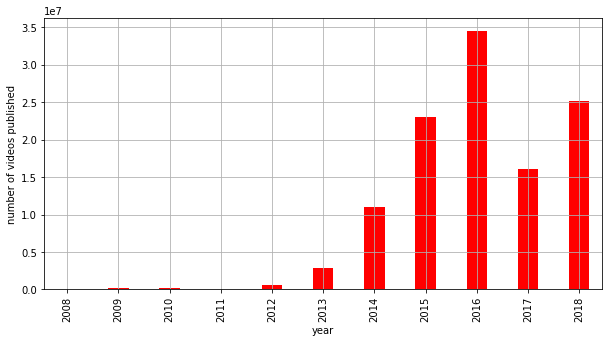

In [80]:
sf.plot_views_per_year(topic_more_extreme)

Een opmerkelijke piek in 2016. Daarna een vrij plotselinge afname en weer een flinke toename dit jaar. Wat zou dat kunnen verklaren? 

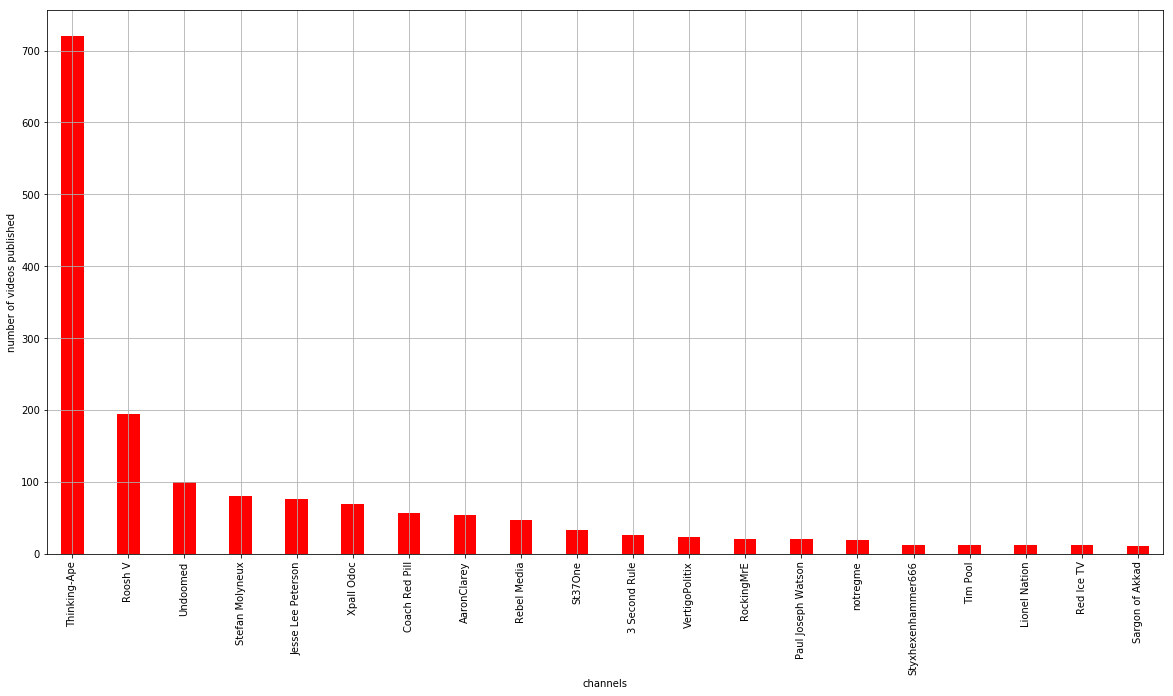

In [82]:
sf.plot_top_channels(topic)

Het lijkt me vrij duidelijk wie bovenop dit onderwerp zit: Thinking Ape. Hij publiceert al jaren zeer actief (722 videos). Laten we hem eens wat nader bekijken. Ik ben ook wel benieuwd naar Jessie Lee Peterson en eigenlijk kan ook Roosh V niet ontbreken. Sargon verdient volgens mij een eigen analyse, net als Stefan Molyneux. 

#### Manosphere - Thinking Ape

In [87]:
channels_of_interest = ['Thinking-Ape']

manosphere = sf.channel_filter(topic, channels_of_interest)

deze selectie levert 720 videos op.


Hoevaak zijn zijn video's bekeken?

In [88]:
manosphere.video_view_count.sum()

5937464.0

Wat is de verdeling van views over tijd?

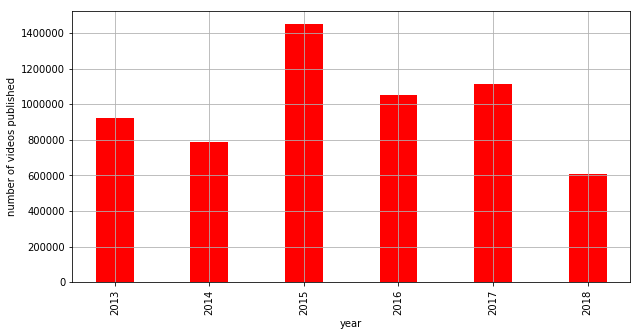

In [89]:
sf.plot_views_per_year(manosphere)

Laten we eens kijken naar de tags die hij gebruikt. 

In [96]:
video_tags = sf.extract_tags(manosphere)

found 1441 unique tags


In [99]:
video_tags.tag.value_counts()[0:40]

stardusk                    718
feminism                    704
hypergamy                   697
briffaults law              688
gynocentrism                683
marriage                    681
male disposability          680
traditionalism              675
divorce                     674
separation                  664
alimony                     650
women initiate divorce      627
prostitutes                 621
masculinity                 617
legal prostitution          614
femininity                  613
women and children first    591
child support               589
male expendability          586
mangina                     581
gold diggers                578
white knight                573
biology                     567
vaginamony                  563
evolution                   561
whores                      556
parasitic women             555
evolutionary psychology     553
briffault                   535
gold digging whores         465
gold digging                439
alpha fu

Even een verklarende woordenlijst:
    
1. Stardusk is [een YouTube-kanaal over MGTOW](https://youtube.com/user/Stardusk/videos). Het zou mij niets verbazen als dit ook van Thinking Ape is omdat hij zichzelf ook zo noemt.
2. Hypergamy is boven je strand trouwen, dus 'marrying up' of 'gold digging'. Zie [Wikipedia](https://en.wikipedia.org/wiki/Hypergamy).
3. Briffault's Law stelt, in hele simpele vorm, dat vrouwen eigenlijk de ultieme baas zijn (zie [dit artikel](https://www.psychologytoday.com/us/blog/machiavellians-gulling-the-rubes/201610/briffaults-law-women-rule) voor extra uitleg).
4. De naam zegt het eigenlijk al, bij gynocentrism draait alles om het gezichtspunt van de vrouw, zie [Wikipedia](https://en.wikipedia.org/wiki/Gynocentrism).
5. Male disposability, ook al zo'n deerniswekkend concept. Blijkbaar ook Male Expandability genoemd, zie [Wikipedia](https://en.wikipedia.org/wiki/Male_expendability).
6. Women initiate divorce slaat op de statistiek dat negentig procent van de echtscheidingen door vrouwen in gang wordt gezet. Zie bijvoorbeeld het [MGTOW-forum](https://www.mgtow.com/forums/topic/80-percent-of-divorces-are-initiated-filed-by-women/)

Meneer heeft trouwens 253 patrons [op patreon.](https://www.patreon.com/user?u=257125)

Al met al zijn die tags behoorlijk grof en vijandig. Opvallend dus ook: die tags is niet wat je in de normale interface van YT ziet. We zouden die tags ook nog over tijd kunnen plotten om iets van een ontwikkeling te zien. Ik weet niet of dat echt veel oplevert in dit geval, maar dan hebben we de code alvast om dat te doen.

In [ ]:
tags_per_year = video_tags.groupby(['tag', 'year']).size().reset_index(name='counts')

# Geef een minimale hoeveelheid aan dat een tag voor moet komen, anders hebben we gewoon teveel.

minimum = 25

tags_per_year = tags_per_year[tags_per_year['counts'] >= minimum]

In [ ]:
tags_per_year.sort_values('year', inplace=True)

In [ ]:
# Schrijf 't naar een csv, zodat we het in gapminder kunnen zien.

tags_per_year.to_csv('output/scenario/tags_per_year_for_' + channel_of_interest + '_.csv', index=False)

TODO: nog even de file aanpassen omdat gapminder 'm niet goed laadt.

Laten we eens naar wat video's gaan kijken. Ik maak een vrij expliciete selectie, bijvoorbeeld op 'whores'.

In [101]:
lookup = sf.tag_filter(video_tags, 'whores')

found 1022 tags


In [103]:
lookup.head()

,video_id,video_title,year,tag
11324,7cpmZRIO41s,Ape Update,2014,gold digging whores
11320,yWUO56N9TWg,Diversifying Announcement,2014,gold digging whores
11317,nqdvv5pdi_A,The Libertarian/Right Dilemma: Women's Suffrag...,2014,gold digging whores
10413,LCWVGwWCZ_Q,MGTOW Talks: In Search Of Motive,2015,gold digging whores
7619,uEMWZS_O7eE,MGTOW Talks: The Matrix of Marketing,2015,gold digging whores


Neem [deze video](https://www.youtube.com/watch?v=8EGN2KfFusM). Invasive species and Human Maladaptation. We zien niet veel. Een kaart van een Australie, met de titel: 'current extent and anticipated distribution of cane toads in australia'. De video gaat over de verdringingen van soorten door menselijk toedoen. Wat heeft dat met de tag 'whores' te maken? Verder is de video niet erg schokkend. Pas later in de video (zo rond 16:00 gaat het over psychologische maladaptation, dat steden bijvoorbeeld verantwoordelijk zijn voor echtscheidingen). Hoe vrouwen zich in stedelijke gebieden gedragen en hoe in rurale gebieden. 

Of [deze video](https://www.youtube.com/watch?v=_XaJHKl8kAY): MGTOW Talks: SJWs And the Blue Pill Rebellion in Gaming. Een gesprek van 1:20 uur, met een vaste gast (Australier en womanizer). Begint met de vraag of SJW's professionele trollen zijn. 'You can't appease these people'. Over gamergate en de Sarkeesian crowd. Opmerkelijke vorm ook: we zien de hele tijd een aankondiging voor een software conferentie. Waarom is dat? 

[Dit](https://www.youtube.com/watch?v=t8eTAsJVnNU) is ook wel een interessant voorbeeld. Lang (bijna twee uur durend gesprek), het is me niet helemaal duidelijk waar 'ie staat. Lijkt zich juist af te zetten tegen alt-right.

Aparte comment, lieflijk haast, spreekt wel over redpilling [zie](https://www.youtube.com/watch?v=Kx-4s1gGOkA&lc=UgjKEwvAkB7XkXgCoAEC)

#### Waar zitten de manospherians nog meer?

Wellicht is het interessant om te kijken naar de commenters. Waar zitten die nog meer? Is dit kanaal, vanuit het perspectief van de reaguurders, deel van een bredere gemeenschap?

Stap 1: even de video_id's in een lijst zetten.

In [107]:
manosphere_movies = set(manosphere.video_id)
len(manosphere_movies)

720

Stap 2: haal deze lijst door alle comments in het rechtse veld om de reaguurders te vinden.

In [112]:
fappers = sf.get_comments_by_video_id(manosphere_movies, 'right')

found 63969 comments 
 and 12769 unique commenters


Bijna 64000 comments gevonden op de video's van Thinking Ape.

Stap 3. Zoek waar deze commenters nog meer hebben gereageerd, zodat we iets kunnen zeggen over de infosphere waar ze inzitten.

In [114]:
fappers_to_search = set(fappers.author_channel_id.unique())
len(fappers_to_search)

12769

In [120]:
faposphere = sf.get_comments_by_author(fappers_to_search, 'right')

found 1287011 comments 
 and 12769 unique commenters


Van deze groep hebben we dus 1,3 miljoen comments gevonden. Waar zitten ze dan?

In [121]:
fappers_united = pd.merge(faposphere, videos_right[['video_id', 
                                                    'video_channel_title',
                                                    'video_tags',
                                                    'video_view_count',
                                                    'video_comment_count']], on='video_id', how='left')

Waar zitten ze?

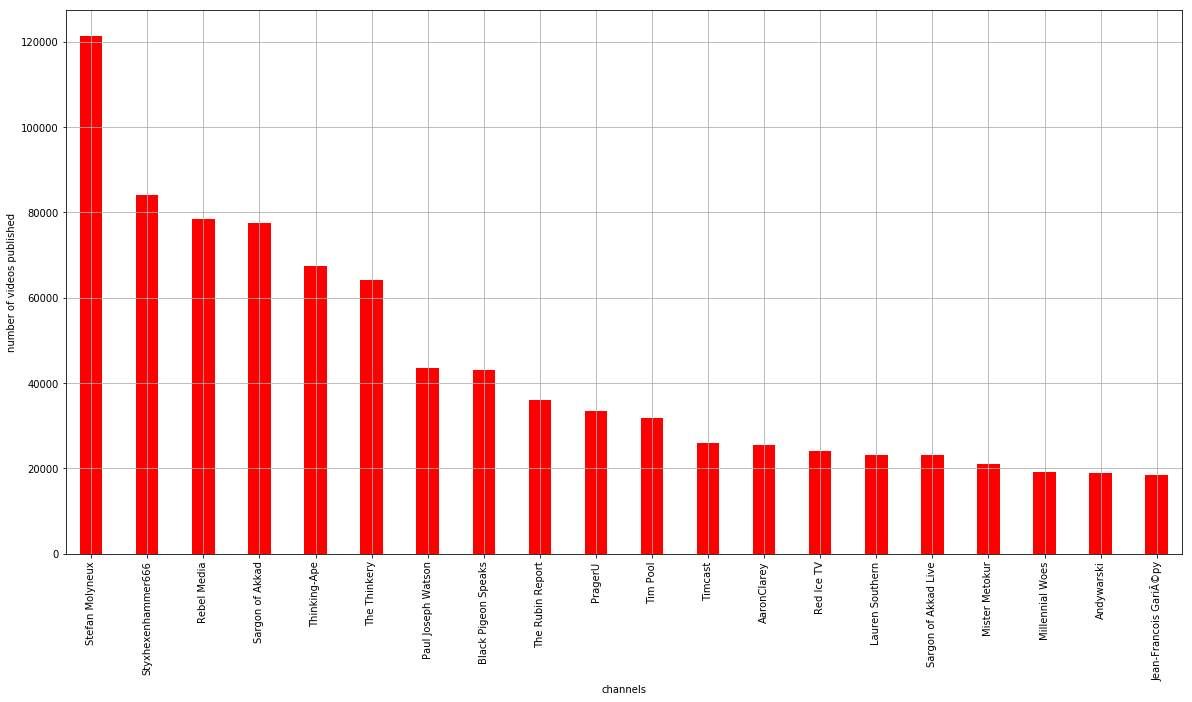

In [122]:
sf.plot_top_channels(fappers_united)

Weinig verrassingen. Stefan Molyneux is wederom populair. Millennial Woes verbaasd me wel, evenals Jean Francois Gariepy. Zit dus lekker in de Alt-right.

Welke reaguurders vallen op?

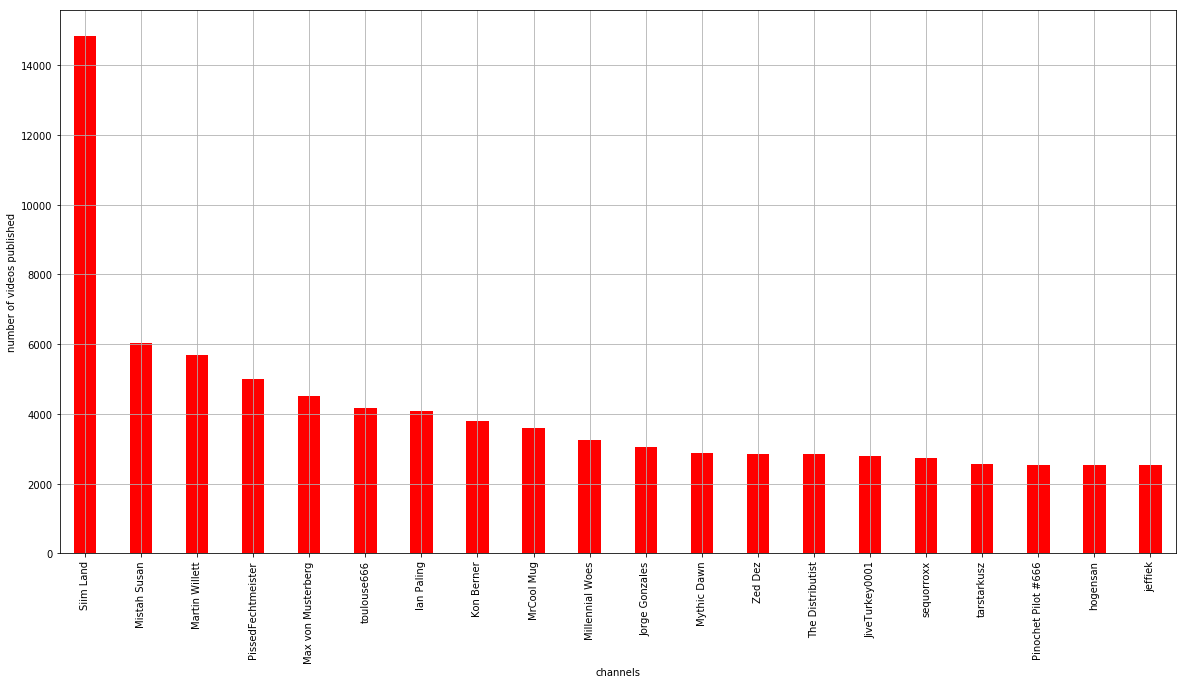

In [126]:
sf.plot_users(fappers_united)

Kijk eens aan. Hier komen we een aantal bekenden tegen, waaronder Mr.CoolMug die ook bij Erkenbrand actief is.
Een aantal anderen zijn ook prominent in de NL scene. Kan zijn dat ze overal prominent zijn en dus ook in de NL scene, maar het zou zo maar kunnen dat dit Nederlanders zijn. 

Ik ga eens kijken naar de ultime topfapper, Siim Land en wat zijn pad is in de Alt-right scene.

In [128]:
siim = sf.zoom_in_on_commenter(fappers_united, 'Siim Land')

Even checken of het echt 1 en dezelfde persoon is.

In [129]:
siim.author_channel_id.nunique()

1

Ja, er is maar een channel id. Die zijn uniek, dus we hebben hier met 1 persoon te maken, of beter gezegd, 1 account. Ik ga het even in [rawgraph](http://rawgraphs.io) bekijken. We hebben niet alle data nodig daarvoor, dus ik maak even een selectie.

In [130]:
siim_grouped = siim.groupby(['year', 'video_channel_title'])['video_channel_title'].agg('count')
siim_grouped

year  video_channel_title    
2016  Siim Land                     53
      Thinking-Ape                   1
2017  Caleb Maddix                   5
      Impact Theory Studios          4
      Jordan B Peterson              2
      Jordan B Peterson Clips        1
      Siim Land                   3364
      Stefan Molyneux                1
      Thinking-Ape                   2
2018  Caleb Maddix                   1
      Gad Saad                       3
      Jordan B Peterson              1
      Siim Land                  11388
      Stefan Molyneux                1
      The Rubin Report               1
      Thinking-Ape                   3
Name: video_channel_title, dtype: int64

Aha. Hij heeft zijn eigen kanaal waar hij erg actief is. Dat is dus niet zo interessant. Laten we dan maar Mr.CoolMug nemen. 

In [131]:
mr_cool = sf.zoom_in_on_commenter(fappers_united, 'MrCool Mug')
mr_cool.author_channel_id.nunique()

1

In [132]:
mr_cool_grouped = mr_cool.groupby(['year', 'video_channel_title'])['video_channel_title'].agg('count')
mr_cool_grouped

year  video_channel_title             
2013  Pat Condell                           3
      The Rubin Report                      1
2014  Pat Condell                           2
      The Rubin Report                      1
2015  American Renaissance                 15
      Ayla Stewart Wife With A Purpose      1
      Babylonian Hebrew                     2
      Gaelic Neoreactionary                 3
      Hel Gower                             2
      Libertarian Realist                  20
      Millennial Woes                     232
      Mister Metokur                        2
      NPI / Radix                           2
      PJ Media                              1
      Pat Condell                           5
      Paul Joseph Watson                   15
      PragerU                               2
      Project England Rising                3
      Quilliam International                1
      Raheem Kassam                         3
      Rebel Media                        

Oke, MrCool Mug zit zo'n beetje overal. Wel een interessante casus hoor. Zie een niet al te beste weergave van zijn ontwikkeling [hier.](https://drive.google.com/open?id=1wCQS-o85-FknSLovHJVjYiovGxH7TVQX) 

Laten we dan toch nog even op zoek gaan naar een hardcore mgtow-er die onder veel mgtow-video's reageert. We zoomen dus weer even uit naar de gemeenschap als geheel.

found 393904 comments 
 and 162242 unique commenters


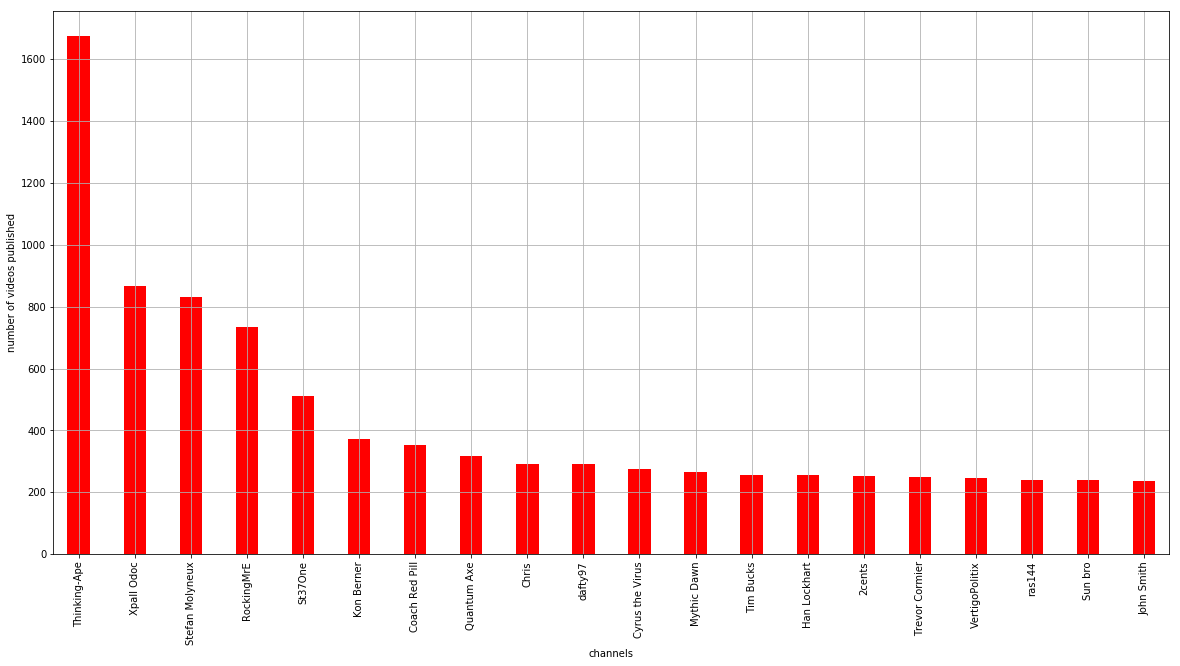

In [136]:
manosphere = set(topic.video_id.unique())
fappers_total = sf.get_comments_by_video_id(manosphere, 'right')


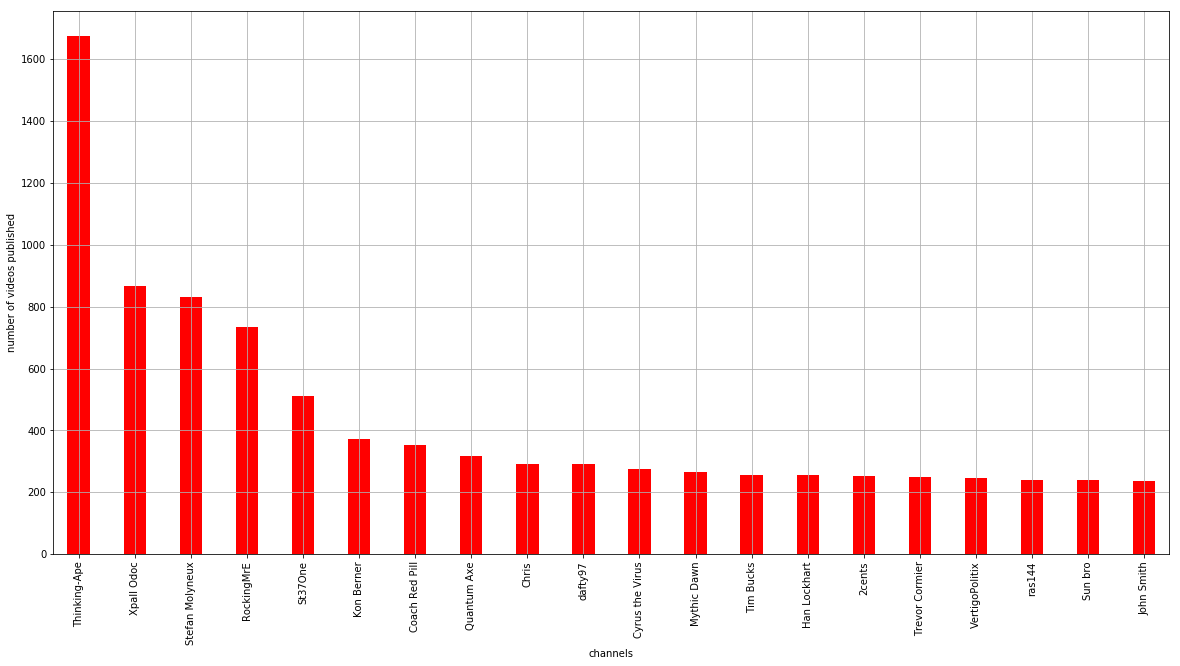

In [137]:
sf.plot_users(fappers_total)

Hmmm. Ik heb er een aantal geprobeerd, maar ik zie vooral dat sommige een eigen kanaal hebben waar ze veel op reageren. Anderen reageren veel op bekende kanalen. Tot nu toe niet echt interessante mensen kunnen vinden. To be continued.

#### Manosphere - Jesse Lee Peterson

Ik ben nog wel benieuwd naar een paar andere kanalen. Dus weer even inzoomen. Ik dacht zelf aan Jesse Lee Peterson en Roosh V. Ik begin met Jesse Lee Peterson, want die ken ik nog niet.


In [138]:
channels_of_interest = ['Jesse Lee Peterson']

manosphere = sf.channel_filter(topic, channels_of_interest)

deze selectie levert 76 videos op.


76

hoe vaak zijn zijn videos bekeken? 

In [139]:
manosphere.video_view_count.sum()

820511.0

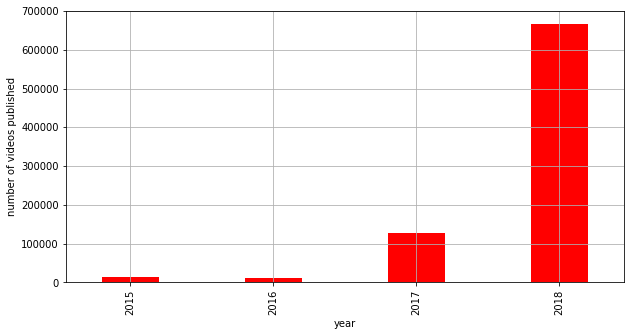

In [140]:
sf.plot_views_per_year(manosphere)

Duidelijk up and coming. Zeker laatste jaar flinke groei.

Laten we ook hier eens naar de tags kijken

In [144]:
vidtags = sf.extract_tags(manosphere)

found 1268 unique tags


In [145]:
lookup = sf.tag_filter(vidtags, 'masculinity')

found 18 tags


In [146]:
lookup

,video_id,video_title,year,tag
711,n5xIK_ezf4Q,Man Confronted Mother for Setting Him Up to Ha...,2018,masculinity
1393,3ngFYUGLiss,"Jul 17: Gavin McInnes, Proud Boy; Trump Met Pu...",2018,masculinity
1389,2_cqTnyUbmU,Aug 6: Women Who Hate Men; Forgive Parents; Do...,2018,masculinity
802,BvkKZeMAEhI,Should Men Share Their Problems with Women? Se...,2018,masculinity
382,6H4OzmPxSxs,"""BETA MALE! NOT AN ALPHA MALE"" -- MOMMY'S BOY!...",2018,masculinity
125,vt2UpMbaVg0,"Society Is Triggered by MEN, But Nobody Respec...",2018,masculinity
486,PkPUjZwaa7U,"What Is a Man? (Actor and ""Raging Liberal"" Jay...",2018,masculinity
3066,WBhSWEyBZrs,"""We Need White Power!"" Rebuilding White Men fo...",2018,masculinity
3071,AbPyGisk8GE,Dr. Warren Farell: The Boy Crisis Is Primarily...,2018,masculinity
951,ubLf4qZqlWQ,"Cenk Uygur on Masculinity, Me Too, âRacism,â...",2018,masculinity


Bevindingen: het is een wat minder vulgair kanaal dan Thinking Ape. 

De beste man klinkt alsof hij dronken is. 

[Video:](https://www.youtube.com/watch?v=cTuFEJD0ggM) why should you forgive 'sexual assault'. Gaat over Asia Argento zaak. God wil dat je voor vergiffenis vraagt en niet zo moeilijk doet. Ik denk niet dat dit kanaal heel interessant is om vanuit de manosphere verder uit te zoek. Vrouwonvriendelijk en antifeministisch? Zeker. Maar interessanter denk ik vanwege de huidskleur van de presentator en omdat 'ie meer in het christelijke uiterst rechtse kamp lijkt te zitten. Dan krijg je al snel het antifemisme erbij.

Laten we daarom nu naar Roosh V kijken.

#### Manosphere - Roosh V

In [147]:
channels_of_interest = ['Roosh V']

manosphere = sf.channel_filter(topic, channels_of_interest)
len(manosphere)

deze selectie levert 194 videos op.


194

Hoeveel views heeft hij gekregen (op dit onderwerp?)

In [148]:
manosphere.video_view_count.sum()

7646145.0

Toch nog ruim zeven miljoen.

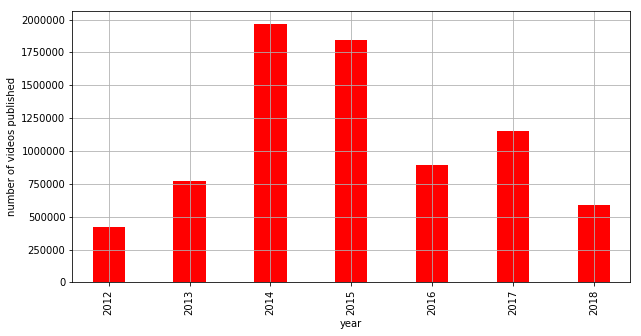

In [149]:
sf.plot_views_per_year(manosphere)

Lijkt wel over zijn piek heen. 

In [151]:
vidtags = sf.extract_tags(manosphere)
vidtags.tag.value_counts()

found 521 unique tags


roosh v                            194
rooshv                             194
roosh                              194
daryush valizadeh                   92
daryush                             91
hangouts on air                     26
#hoa                                26
#hangoutsonair                      26
girls                               10
game                                 8
montreal                             6
ukraine                              6
pua                                  6
pickup                               6
feminism                             5
toronto                              5
women                                5
canada                               4
ð¾ð´ðµñð°                           4
trump                                4
odessa                               4
sjw                                  4
feminists                            4
travel                               4
mgtow                                3
turkey                   

Weinig interessants te vinden in zijn hashtags. Maar ik ben wel benieuwd naar zijn achterban.

In [153]:
manosphere_movies = set(manosphere.video_id)
len(manosphere_movies)

194

In [154]:
roosh = sf.get_comments_by_video_id(manosphere_movies, 'right')

found 0 comments 
 and 0 unique commenters


hier gaat iets nog niet goed. nog ff checken. Ik wil niet te lang stilstaan bij de manosphere. Mochten we hier  verder mee willen, dan kunnen we er alsnog induiken.

### Geweld

Kunnen we een beeld krijgen van geweldsrethoriek?

### Antisemitisme

Ik hou de termen even beperkt. Als je bijvoorbeeld op Soros zoekt, krijg je erg veel terug dat mogelijk, maar niet per se antisemitisch hoeft te zijn. Daarom gebruik ik liever termen die minder dubbelzinnig zijn. Daarnaast lijkt het me verstandig om niet alleen in de tags te zoeken, maar ook in de beschrijvingen en comments. 

In [155]:
query_topic = 'antisemitism'

query = ['holohoax', '^jq', 'jewish question',
         'goy', 'schlom', 'shekel',
         'zog', 'zionis', 'zion wa'
        ]

In [156]:
jews = sf.topic_filter(videos_right, query, query_topic)

found 1636 videos with antisemitism


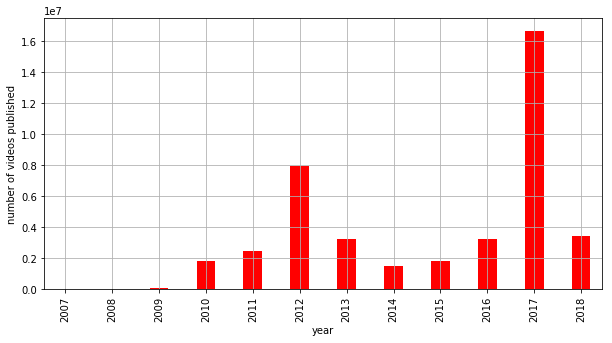

In [157]:
sf.plot_views_per_year(jews)

Wat een gekke verdeling. Klopt dit wel? 

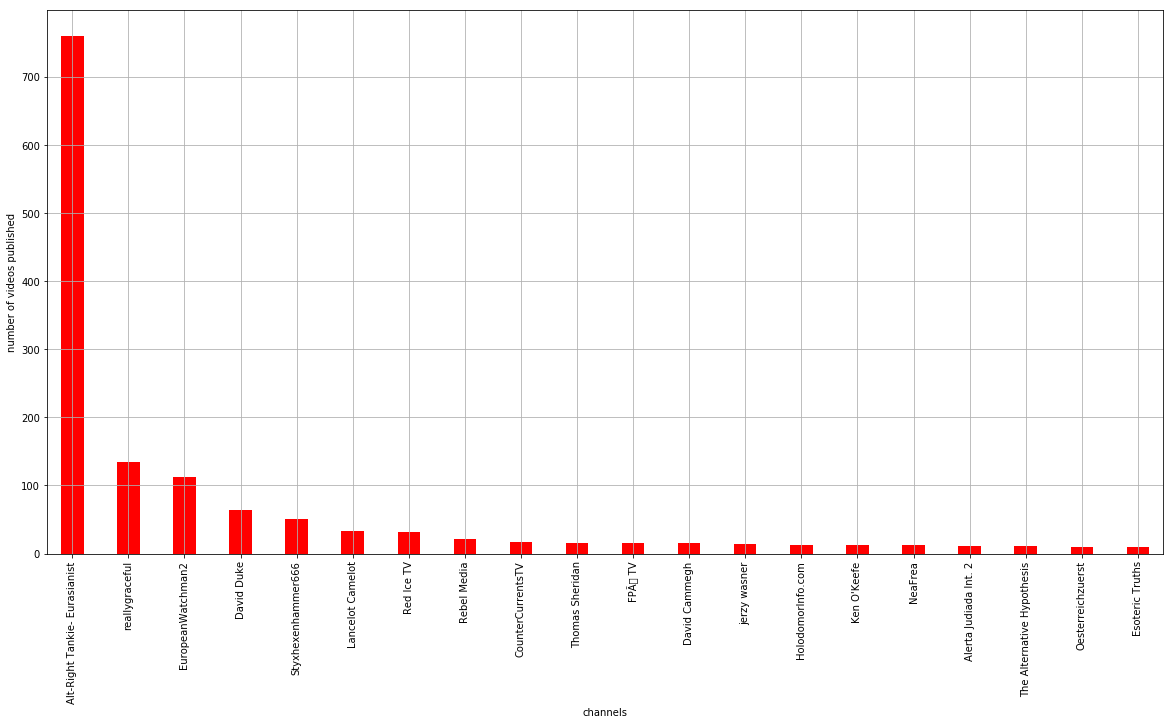

In [158]:
sf.plot_top_channels(jews)

Ik vermoed dat niet alle kanalen antisemitisch zijn. Ik zou eerder zeggen dat bijvoorbeeld Red Ice TV juist niet antisemitisch is, maar dat lijkt me iets om uit te zoeken. Sowieso is Alt-Right Tankie een erg interessant kanaal, ook omdat die populair is bij Erkenbrand. 

Dit zijn denk ik de stappen:
1. Eens kijken wat voor videos ik nu teruggekregen heb. Mogelijk moet ik de tags nog wat aanpassen.
2. De verschillende kanalen en hun achterban onderzoeken, in ieder geval de top3 en ik ben ook benieuwd naar FPO TV (misschien zit er iets in hun tags dat ze niet in het openbaar zeggen), Red Ice TV en Rebel Media.


In [159]:
jews.sample(20)

,video_id,video_published,channel_id,video_title,video_description,video_channel_title,video_tags,video_category_id,video_default_language,video_duration,video_view_count,video_comment_count,video_likes_count,video_dislikes_count,video_topic_ids,video_topic_categories,year,yearmonth
193871,GD8YhvnfLmw,2013-09-28T10:59:52.000Z,UCHdemBio61IVEuFFCpDuCsA,'Adolf Hitler The Greatest Story Never Told Pa...,DVD NOW AVAILABLE http://thegreateststorynever...,The Greatest Story Never Told TV,"['The Greatest Story Never Told', 'World War I...",27.0,not set,PT15M6S,44569.0,83.0,192.0,23.0,"['/m/01h6rj', '/m/098wr', '/m/098wr', '/m/0f2f9']",['https://en.wikipedia.org/wiki/Television_pro...,2013,2013-09
34643,TqzHgtN-VyY,2016-12-14T11:47:09.000Z,UCFWmmu2MmGW8Obc5pNDDJmw,The Daily Traditionalist All Stand Together 11...,NaN,Alt-Right Tankie- Eurasianist,"['andrey r. bens', 'christopher hitchens', 'bi...",22.0,not set,PT30M50S,20.0,0.0,1.0,0.0,"['/m/02jjt', '/m/02jjt']",['https://en.wikipedia.org/wiki/Entertainment'],2016,2016-12
34220,mqF4HHxHoM0,2017-06-18T08:54:22.000Z,UCFWmmu2MmGW8Obc5pNDDJmw,"Robert Wistrich: ""Antisemitism"" and the Left F...",NaN,Alt-Right Tankie- Eurasianist,"['jared taylor', 'libertarian realist', 'sinea...",22.0,not set,PT1H53M32S,18.0,0.0,0.0,0.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2017,2017-06
34337,2xqh_kqruEE,2017-04-06T12:00:23.000Z,UCFWmmu2MmGW8Obc5pNDDJmw,Trump Questions Israeli Commitment to Peace Deal,Description,Alt-Right Tankie- Eurasianist,"['christopher hitchens', 'bill maher', 'michae...",22.0,not set,PT2M6S,12.0,1.0,2.0,0.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2017,2017-04
149416,JQzvViVRjOo,2017-04-24T23:56:26.000Z,UC0rZoXAD5lxgBHMsjrGwWWQ,Israel Fires on Pro-Assad Forces in Syria over...,Support my work via donation:\n\nPatreon: http...,Styxhexenhammer666,"['israel', 'israel syria', 'assad', 'bashar al...",25.0,not set,PT8M9S,26808.0,721.0,1731.0,59.0,"['/m/098wr', '/m/05qt0', '/m/098wr', '/m/05qt0']","['https://en.wikipedia.org/wiki/Society', 'htt...",2017,2017-04
34429,CAO9wVIR0vs,2017-02-21T09:10:23.000Z,UCFWmmu2MmGW8Obc5pNDDJmw,"Sam Harris: Defending Holocaust Revisionism ""D...",NaN,Alt-Right Tankie- Eurasianist,"['christopher hitchens', 'bill maher', 'michae...",22.0,not set,PT20S,74.0,0.0,0.0,0.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2017,2017-02
174156,kw4cxHUNnjE,2010-10-20T14:39:59.000Z,UCDpPYb8N7CCcAaDrCptF6TQ,Belgenfabriek draait verder.,"Terwijl alles in dit land geblokkeerd is, draa...",Vlaams Belang,"['Filip De Man', 'Hagen Goyvaerts', 'Naturalis...",25.0,not set,PT2M52S,1467.0,0.0,0.0,0.0,not set,not set,2010,2010-10
34708,r5M-XbMowxU,2016-12-13T11:32:28.000Z,UCFWmmu2MmGW8Obc5pNDDJmw,Robert Spencer on CAIR's Promotion of Hate Cri...,NaN,Alt-Right Tankie- Eurasianist,"['andrey r. bens', 'christopher hitchens', 'bi...",22.0,not set,PT7M12S,23.0,1.0,2.0,0.0,"['/m/098wr', '/m/06bvp', '/m/098wr', '/m/06bvp']","['https://en.wikipedia.org/wiki/Religion', 'ht...",2016,2016-12
37924,IH9_1Cvk7Cs,2016-11-15T06:41:50.000Z,UCFUC7NaTxZanB_FVOJN92eg,John Lash - Eight Unifying Points for Truth Se...,"John Lash is a self-educated, free-lance schol...",Red Ice TV,"['Red Ice Radio', 'John Lash', 'Unifying Point...",25.0,not set,PT2H19M54S,22672.0,164.0,449.0,63.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2016,2016-11
34446,O1mHQi4_fB8,2017-02-21T11:45:08.000Z,UCFWmmu2MmGW8Obc5pNDDJmw,Anni Cyrus Women Under Sharia Radio 3Fourteen,NaN,Alt-Right Tankie- Eurasianist,"['christopher hitchens', 'bill maher', 'michae...",22.0,not set,PT1H3M11S,32.0,0.0,1.0,0.0,"['/m/098wr', '/m/06bvp', '/m/098wr', '/m/06bvp']","['https://en.wikipedia.org/wiki/Society', 'htt...",2017,2017-02


Nogal wat videos gaan juist over antisemitsme op links.

In [160]:
rebel = topic[topic['video_channel_title'] == 'Rebel Media']
len(rebel)

47

In [161]:
rebel

,video_id,video_published,channel_id,video_title,video_description,video_channel_title,video_tags,video_category_id,video_default_language,video_duration,video_view_count,video_comment_count,video_likes_count,video_dislikes_count,video_topic_ids,video_topic_categories,year,yearmonth
200912,F54oPULS2E0,2018-10-13T19:35:14.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,âBoys Will be Boysâ wine pulled because â...,David Menzies of The Rebel.Media reports: In t...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'David M...",25.0,not set,PT3M54S,12916.0,294.0,782.0,7.0,"['/m/05qt0', '/m/098wr', '/m/098wr']","['https://en.wikipedia.org/wiki/Politics', 'ht...",2018,2018-10
201401,VgJLXvYn0ro,2018-08-13T20:55:29.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,New Terminator movie terminates men | Ben Davies,Ben Davies of The Rebel.Media reports: The mom...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'Ben Dav...",25.0,not set,PT3M39S,33274.0,1245.0,2385.0,44.0,"['/m/02vxn', '/m/02jjt', '/m/02jjt', '/m/02vxn']",['https://en.wikipedia.org/wiki/Entertainment'...,2018,2018-08
202001,ZWXOUVyFVFs,2018-06-15T20:18:54.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,Rob Shimshock: Prof Calls Jordan Peterson An '...,Rob Shimshock of Campus Unmasked investigates ...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'Rob Shi...",25.0,not set,PT5M32S,41698.0,399.0,1925.0,58.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2018,2018-06
202256,LNJnDKDN73w,2018-05-19T14:00:03.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,Omitting âhateâ facts in migrant rape case...,Ezra Levant of The Rebel.Media reports: On las...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'Ezra Le...",25.0,not set,PT2M9S,9428.0,110.0,643.0,6.0,"['/m/05qt0', '/m/098wr', '/m/098wr']","['https://en.wikipedia.org/wiki/Society', 'htt...",2018,2018-05
202333,y_FFXdvH-J0,2018-05-10T22:51:10.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,CBC reports teenâs âtantrumâ over dress ...,Sheila Gunn Reid of The Rebel.Media reports: T...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'Sheila ...",25.0,not set,PT7M49S,18549.0,331.0,1021.0,45.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2018,2018-05
202408,goMaliYCats,2018-05-02T21:49:56.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,Left drops rule against reporting terroristâ...,David Menzies of The Rebel.Media reports: As d...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'David M...",25.0,not set,PT5M17S,10577.0,165.0,797.0,11.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2018,2018-05
202446,uxUZ7Y-Yp9o,2018-04-28T21:02:42.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,âExcuse shoppingâ in aftermath of Toronto ...,David Menzies of The Rebel.Media reports: On F...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'David M...",25.0,not set,PT4M53S,22603.0,389.0,1104.0,37.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2018,2018-04
203259,VgJLXvYn0ro,2018-08-13T20:55:29.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,New Terminator movie terminates men | Ben Davies,Ben Davies of The Rebel.Media reports: The mom...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'Ben Dav...",25.0,not set,PT3M39S,33274.0,1245.0,2385.0,44.0,"['/m/02vxn', '/m/02jjt', '/m/02jjt', '/m/02vxn']","['https://en.wikipedia.org/wiki/Film', 'https:...",2018,2018-08
204701,o8DhmEunckg,2017-08-14T23:33:16.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,Gavin McInnes: Who is REALLY to blame for Char...,(LANGUAGE WARNING) Gavin McInnes of TheRebel.m...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'Charlot...",25.0,not set,PT8M11S,483281.0,3897.0,16134.0,2518.0,"['/m/098wr', '/m/098wr', '/m/0f2f9']",['https://en.wikipedia.org/wiki/Television_pro...,2017,2017-08
204753,NRdzCQe7GuE,2017-08-04T22:45:44.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,No Rape Culture at Australian Uni's: Even Sein...,Mark Latham reports on the trickery that the A...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'mark la...",25.0,not set,PT6M22S,25642.0,336.0,1946.0,16.0,"['/m/098wr', '/m/098wr', '/m/0f2f9']",['https://e

Bijvoorbeeld bij Rebel Media. Ik wil ook nog even Red Ice TV checken. Waarschijnlijk zien we daar hetzelfde

In [162]:
redice = topic[topic['video_channel_title'] == 'Red Ice TV']
len(redice)

12

In [163]:
redice

,video_id,video_published,channel_id,video_title,video_description,video_channel_title,video_tags,video_category_id,video_default_language,video_duration,video_view_count,video_comment_count,video_likes_count,video_dislikes_count,video_topic_ids,video_topic_categories,year,yearmonth
37454,QaeXk-g8ouw,2018-08-24T19:29:38.000Z,UCFUC7NaTxZanB_FVOJN92eg,How 'Right Wing' Is Australia? - Sydney Watson,Sydney Watson is an Australian-American journa...,Red Ice TV,"['Australia', 'right wing', 'conservatism', 'L...",25.0,not set,PT48M40S,43321.0,1670.0,2663.0,102.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2018,2018-08
37522,GJ2ahf8JvJU,2018-05-11T21:46:02.000Z,UCFUC7NaTxZanB_FVOJN92eg,The Incel Rebellion - Roger Devlin,"F. Roger Devlin, Ph.D., is an independent scho...",Red Ice TV,"['Alek Minassian', 'anti-feminism', 'Canada', ...",25.0,not set,PT48M17S,44745.0,1848.0,1303.0,138.0,"['/m/04rlf', '/m/04rlf']",['https://en.wikipedia.org/wiki/Music'],2018,2018-05
37598,9gSelFxICCw,2018-01-31T09:27:33.000Z,UCFUC7NaTxZanB_FVOJN92eg,'Safe Shorts' to Stop Rape in Germany,Germany has a rape problem thanks to their ope...,Red Ice TV,"['Red Ice TV', 'Germany', 'Rape', 'Refugees', ...",25.0,not set,PT7M42S,39522.0,974.0,1783.0,58.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2018,2018-01
37609,fKKcSXQB-YE,2018-01-15T23:19:20.000Z,UCFUC7NaTxZanB_FVOJN92eg,"Oprah #MeToo #TimesUp Movement Ignores ""Migran...",Lana comments on the hypocrisy and blatant ant...,Red Ice TV,"['Red Ice TV', 'Lana Lokteff', '#MeToo', 'Rape...",25.0,not set,PT19M48S,215957.0,5375.0,12650.0,445.0,"['/m/098wr', '/m/098wr', '/m/0f2f9']","['https://en.wikipedia.org/wiki/Society', 'htt...",2018,2018-01
37624,sDD15tXH4IQ,2017-12-16T01:44:46.000Z,UCFUC7NaTxZanB_FVOJN92eg,Whoâs Doing the Raping in the UK? - Seeking ...,Patrick takes a look at a recent study on groo...,Red Ice TV,"['UK', 'Rape', 'Britain', 'Migrants', 'Rape Cu...",25.0,not set,PT3M58S,25108.0,692.0,2206.0,58.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2017,2017-12
37632,Tlx6YvbXng8,2017-12-01T03:18:12.000Z,UCFUC7NaTxZanB_FVOJN92eg,Womenâs Roundtable - Debunking the Claim tha...,This group discussion includes Ayla (Wife With...,Red Ice TV,"['Radio 3Fourteen', 'Women', 'Nationalism', 'A...",25.0,not set,PT1H4M36S,34726.0,1044.0,1731.0,94.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2017,2017-12
37775,NRfNn5OnasE,2017-05-10T01:29:26.000Z,UCFUC7NaTxZanB_FVOJN92eg,The Handmaid's Tale: Feminist Anti-White Male ...,Henrik and Lana show clips from The Handmaid's...,Red Ice TV,"['Red Ice TV', ""The Handmaid's Tale"", ""Handmai...",25.0,not set,PT8M33S,121136.0,797.0,1505.0,689.0,"['/m/0f2f9', '/m/02vxn', '/m/02jjt', '/m/02jjt...","['https://en.wikipedia.org/wiki/Film', 'https:...",2017,2017-05
37873,QFtOea2iEzI,2017-01-17T06:26:46.000Z,UCFUC7NaTxZanB_FVOJN92eg,Feminist Knits from Yarn Pulled Out of Her Vagina,A feminist knits with wool that has been inser...,Red Ice TV,"['Red Ice Live', 'Red Ice TV', 'Weekend Warrio...",25.0,not set,PT6M40S,31306.0,310.0,500.0,48.0,"['/m/019_rr', '/m/03glg', '/m/019_rr', '/m/03g...",['https://en.wikipedia.org/wiki/Lifestyle_(soc...,2017,2017-01
37874,CLWp-m2cd_U,2017-01-17T06:37:34.000Z,UCFUC7NaTxZanB_FVOJN92eg,Jim Goad - The War on Whites Reaches New Heights,Jim Goad is an American author and publisher. ...,Red Ice TV,"['Red Ice Radio', 'Jim Goad', 'War on Whites',...",25.0,not set,PT54M13S,188991.0,1917.0,5120.0,252.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2017,2017-01
37881,hLlhW29b0bA,2016-12-24T09:03:17.000Z,UCFUC7NaTxZanB_FVOJN92eg,Ingrid & Conrad - Merry Yule: Swedish Governme...,Ingrid Carlqvist worked in mainstream media fo...,Red Ice TV,"['Red Ice Radio', 'Ingrid & Conrad', 'Sweden',...",25.0,not set,PT53M58S,17001.0,222.0,552.0,24.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2016,2016-12


Nou.... volgens mij is daar toch wel wat meer aan de hand... Maar goed dat we even gechecked hebben.

Wellicht is het een idee om een selectie te maken van kanalen die mogelijk antisemetische content herbergen. Ik stel voor om het bij 10 af te kappen, dus alle kanalen die 10 videos of meer hebben. Er zitten nogal wat conspiracy-achtige kanalen bij, maar dat is natuurlijk niet zo verwonderlijk.

In [165]:
to_keep = ['Alt-Right Tankie- Eurasianist', 
           'reallygraceful',
           'EuropeanWatchman2',
           'David Duke',
           'Red Ice TV',
           'CounterCurrentsTV',
           'David Cammegh',
           'HolodomorInfo.com',
           'NeaFrea',
           "Ken O'Keefe",
           'The Alternative Hypothesis',
           'Alerta Judiada Int. 2',
           'Esoteric Truths',
           'Verbo Tempestas',
           'RoibeÃ¡rd Mac Seafraidh',
           'Electre',
          ]

In [166]:
antisemites = sf.channel_filter(jews, to_keep)

deze selectie levert 1226 videos op.


1226

Waar zitten de commenters nog meer?

In [ ]:
antisemites_vids = set(antisemites.video_id.unique())
antisemites = sf.get_comments_by_video_id(antisemites_vids, 'right')

In [ ]:
nazis_united = pd.merge(antisemites, videos_right[['video_id', 
                                                    'video_channel_title',
                                                    'video_tags',
                                                    'video_view_count',
                                                    'video_comment_count']], on='video_id', how='left')

In [ ]:
sf.plot_chann(nazis_united)

In [ ]:
topnazis = nazis_united.author_display_name.value_counts()[0:20]
fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

width = 0.4

ax = fig.add_subplot(111) 

topnazis.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of comments')
ax.set_xlabel('year')

plt.show()